In [1]:
#https://keras.io/examples/ -> Timeseries classification
#https://keras.io/examples/timeseries/eeg_signal_classification/
#https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os

#date = "230324"
date = "230517"
DATA_DIR = os.path.join("..", date)

import pandas as pd
import numpy as np
import math
from statistics import mean
import matplotlib.pyplot as plt
from itertools import groupby

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import preprocessing, model_selection

In [3]:
run_num = 1
post_op = True
#filename = "Run_1_attention.xlsx"
if date == "230324":
    filename = "Run_" + str(run_num) +"_attention.xlsx"
elif date == "230517":
    if run_num == 1:
        filename = "20230517T074332Z.xlsx"
    elif run_num == 2:
        filename = "20230517T084019Z.xlsx"
    else:
        filename = "20230517T100316Z.xlsx"

output_filename = "av_metrics_" + date + "_run" + str(run_num) + ".csv"

full_filename = os.path.join(DATA_DIR, filename)


In [4]:
df = pd.read_excel(full_filename)
print(df.head(1))

   Recording timestamp  Computer timestamp Sensor Recording start time  \
0                    0                   0    NaN         09:43:32.124   

   Recording duration Recording Fixation filter name           Event  \
0             2815701         Tobii I-VT (Attention)  RecordingStart   

   Pupil diameter left  Pupil diameter right  Pupil diameter filtered  \
0                  NaN                   NaN                      NaN   

  Eye movement type  Gaze event duration  Eye movement type index  
0          Fixation                   97                        1  


In [5]:
if date == "230324":
    if run_num == 1:
        filename = "Wl1_Friedrik_230324_093826.csv"
    else:
        filename = "Wl2_Fredrik_230324_112649.csv"
elif date == "230517":
    if run_num == 1:
        filename = "Exp1_Fredrick_230517_084542.csv"
    elif run_num == 2:
        filename = "Exp2_Fredrick2_230517_094640.csv"
    else:
        filename = "Exp3_Fredrick_230517_111130.csv"

full_filename = os.path.join(DATA_DIR, filename)

score_df = pd.read_csv(full_filename, sep=' ',index_col=False)
#print(score_df.head(1))

score_df['score'] = score_df['score'].replace([0], 10)

all_scores = list(score_df['score'])
if post_op:
    all_scores_post_op = list(score_df['post_op_score'])

In [6]:
sec_in_ms=0.000001
timeIntervalDuration = 180 #sec

def getTimeInterval(ms_num):

    return math.ceil(ms_num*sec_in_ms/timeIntervalDuration)

#df = df.drop([0])
#fill the null rows with the mean of respective columns
df = df.fillna(df.mean())
df['timeInterval'] = df.apply(lambda row: getTimeInterval(row['Computer timestamp']), axis=1)
df = df.drop(columns=['Recording timestamp','Computer timestamp','Sensor', 'Recording start time',
                      'Recording duration', 'Recording Fixation filter name', 'Event', 'Eye movement type',
                     'Gaze event duration', 'Eye movement type index'])

In [7]:
df = df.drop([0])
print(df.head(5))

   Pupil diameter left  Pupil diameter right  Pupil diameter filtered  \
1                3.091                 3.131                    3.111   
2                3.082                 3.131                    3.106   
3                3.080                 3.097                    3.090   
4                3.083                 3.099                    3.089   
5                3.078                 3.094                    3.089   

   timeInterval  
1             1  
2             1  
3             1  
4             1  
5             1  


In [8]:
last_timeInterval = list(df['timeInterval'])[-1]
print(last_timeInterval)

#diameters_df = pd.DataFrame(columns = ['Pupil diameter left', 'Pupil diameter right', 'Pupil diameter filtered',
diameters_df = pd.DataFrame(columns = ['Pupil diameter right', 'Pupil diameter filtered',
                                       'Min num'
                                      ])
intervals = []

#features = ['Pupil diameter left', 'Pupil diameter right', 'Pupil diameter filtered']
features = ['Pupil diameter right', 'Pupil diameter filtered']
for ti in range (1, last_timeInterval + 1):
    ti_df = df[df['timeInterval']==ti]
    row_lst = []
    nums = []
    for feature in features:
        feature_lst = ti_df[feature].tolist()
        row_lst.append(feature_lst)
        nums.append(len(feature_lst))
    
    row_lst.append(min(nums))
    diameters_df.loc[ti-1] = row_lst
    intervals.append(ti)

#print(diameters_df.tail())
#print(diameters_df.shape)

minNum = min(diameters_df['Min num'])
print(minNum)

for index, row in diameters_df.iterrows():
    for feature in features:
        lst = diameters_df.at[index, feature]
        diameters_df.at[index, feature] = lst[-abs(minNum):]
  
window_size = minNum
diameters_df = diameters_df.drop(columns=['Min num'])

num_values = len(diameters_df.iloc[0]['Pupil diameter filtered'])
print(num_values)

16
5798
5798


In [9]:
print(len(all_scores))

intervals_num = len(intervals)
print(intervals_num)
if len(all_scores) > intervals_num:
    scores = all_scores[1:intervals_num+1]
    if post_op:
        scores_post_op = all_scores_post_op[1:intervals_num+1]
else:
    scores = all_scores[1:]
    if post_op:
        scores_post_op = all_scores_post_op[1:]
print(len(scores))

number_of_points = len(scores)

intervals = intervals[0:number_of_points]
diameters_df = diameters_df.head(number_of_points)
print(diameters_df.head(1))

15
16
14
                                Pupil diameter right  \
0  [3.133, 3.138, 3.118, 3.12, 3.137, 3.13, 3.102...   

                             Pupil diameter filtered  
0  [3.082, 3.084, 3.09, 3.089, 3.084, 3.084, 3.07...  


In [10]:
scaler = preprocessing.MinMaxScaler()
#scale the values
for index, row in diameters_df.iterrows():
    for feature in features:
        current_diams = diameters_df.at[index, feature]
        diameters_df.at[index, feature] = scaler.fit_transform(np.asarray(current_diams).reshape(-1, 1))
        
le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(scores)
scores = le.transform(scores)
print(diameters_df.head())

                                Pupil diameter right  \
0  [[0.22376692456479685], [0.22437137330754348],...   
1  [[0.21075625188309738], [0.22536908707442005],...   
2  [[0.22561048384731147], [0.22561048384731147],...   
3  [[0.25685705066150366], [0.2520167796063246], ...   
4  [[0.2782126549249837], [0.2765818656229616], [...   

                             Pupil diameter filtered  
0  [[0.32805164319248825], [0.32844287949921747],...  
1  [[0.23225677830940994], [0.2420255183413078], ...  
2  [[0.29963287207003675], [0.29624399887037556],...  
3  [[0.47936726272352126], [0.47902338376891307],...  
4  [[0.3241075010028079], [0.3241075010028079], [...  


In [11]:
# create numpy array for X
# diameters_np shape (a,b,c): # a - number of time periods, b - number of features, c - number of measures per time period
diameters_np = np.empty(0)

for index in range(0, number_of_points):
    for feature in features:
        new_np = np.array(diameters_df.at[index, feature])
        diameters_np = np.append(diameters_np, new_np)
        
diameters_np = diameters_np.reshape([number_of_points, len(features), window_size])
print(diameters_np)


[[[0.22376692 0.22437137 0.22195358 ... 0.22509671 0.22340426 0.21723888]
  [0.32805164 0.32844288 0.32961659 ... 0.32805164 0.32942097 0.32805164]]

 [[0.21075625 0.22536909 0.25760771 ... 0.23470925 0.23335342 0.23817415]
  [0.23225678 0.24202552 0.25777512 ... 0.24780702 0.24700957 0.24521531]]

 [[0.22561048 0.22561048 0.18234049 ... 0.18113093 0.1738736  0.17780466]
  [0.29963287 0.296244   0.29003106 ... 0.23044338 0.23270263 0.23242022]]

 ...

 [[0.21445817 0.18152325 0.14537309 ... 0.21952727 0.22586127 0.22694268]
  [0.49189789 0.47436182 0.45682575 ... 0.38601554 0.39067703 0.39067703]]

 [[0.14942926 0.14873746 0.14919866 ... 0.17929206 0.17940736 0.17929206]
  [0.32297863 0.32275832 0.322538   ... 0.40868033 0.40868033 0.4082397 ]]

 [[0.16551118 0.16697588 0.16756176 ... 0.29616248 0.3223318  0.25388146]
  [0.23282388 0.23382374 0.23439509 ... 0.30024282 0.32295386 0.34209399]]]


4
<class 'int'>


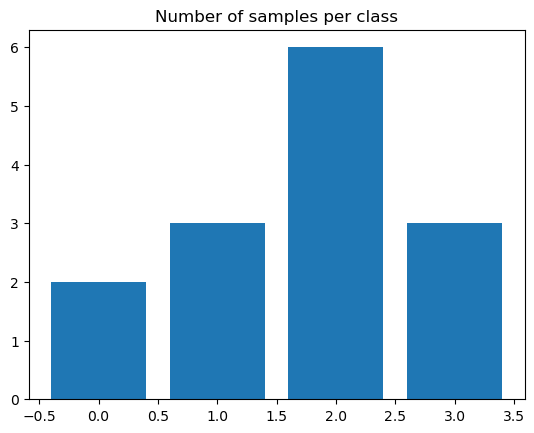

In [12]:
num_classes = len(set(scores))
unique, counts = np.unique(scores, return_counts=True)
print(num_classes)
print(type(num_classes))
plt.bar(range(num_classes), counts)
plt.title("Number of samples per class")
plt.show()

In [13]:
# Spit the data into train and test
print(diameters_np.shape)
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(
    diameters_np, scores, test_size=0.15, random_state=42, shuffle=True
)

np.split(diameters_np, [])

print(
    f"Length of train_X : {len(train_X)}\nLength of test_X : {len(test_X)}\nLength of train_Y : {len(train_Y)}\nLength of test_Y : {len(test_Y)}"
)

(14, 2, 5798)
Length of train_X : 11
Length of test_X : 3
Length of train_Y : 11
Length of test_Y : 3


In [14]:
# Reshape the data
x_train = np.asarray(train_X).astype(np.float32).reshape(-1, len(features)*window_size, 1)
y_train = np.asarray(train_Y).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(test_X).astype(np.float32).reshape(-1, len(features)*window_size, 1)
y_test = np.asarray(test_Y).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

In [15]:
#BATCH_SIZE = 64
BATCH_SIZE = 2
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [16]:
vals_dict = {}
for i in scores:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{1: 0.7857142857142857, 0: 0.8571428571428572, 2: 0.5714285714285714, 3: 0.7857142857142857}


In [17]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [18]:
def create_model():
    input_layer = keras.Input(shape=(len(features)*window_size, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [19]:
conv_model = create_model()

print(conv_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11596, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 5798, 32)          128       
                                                                 
 batch_normalization (Batch  (None, 5798, 32)          128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 2899, 64)          6208      
                                                                 
 batch_normalization_1 (Bat  (None, 2899, 64)          256       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 1450, 128)         41088 

In [20]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()

In [21]:
conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

Epoch 1/5
6/6 [==============================] - 74s 13s/step - loss: 84.6657 - top_k_categorical_accuracy: 0.9091 - auc: 0.6419 - precision: 0.5455 - recall: 0.5455 - val_loss: 33.9581 - val_top_k_categorical_accuracy: 1.0000 - val_auc: 0.8519 - val_precision: 0.3333 - val_recall: 0.3333 - lr: 0.0010
Epoch 2/5
6/6 [==============================] - 36s 6s/step - loss: 125.5007 - top_k_categorical_accuracy: 0.9091 - auc: 0.4353 - precision: 0.1818 - recall: 0.1818 - val_loss: 28.7336 - val_top_k_categorical_accuracy: 1.0000 - val_auc: 0.7407 - val_precision: 0.3333 - val_recall: 0.3333 - lr: 0.0010
Epoch 3/5
6/6 [==============================] - 74s 14s/step - loss: 30.7810 - top_k_categorical_accuracy: 1.0000 - auc: 0.9339 - precision: 0.8182 - recall: 0.8182 - val_loss: 158.9863 - val_top_k_categorical_accuracy: 1.0000 - val_auc: 0.5556 - val_precision: 0.3333 - val_recall: 0.3333 - lr: 0.0010
Epoch 4/5
6/6 [==============================] - 37s 6s/step - loss: 84.1704 - top_k_categ

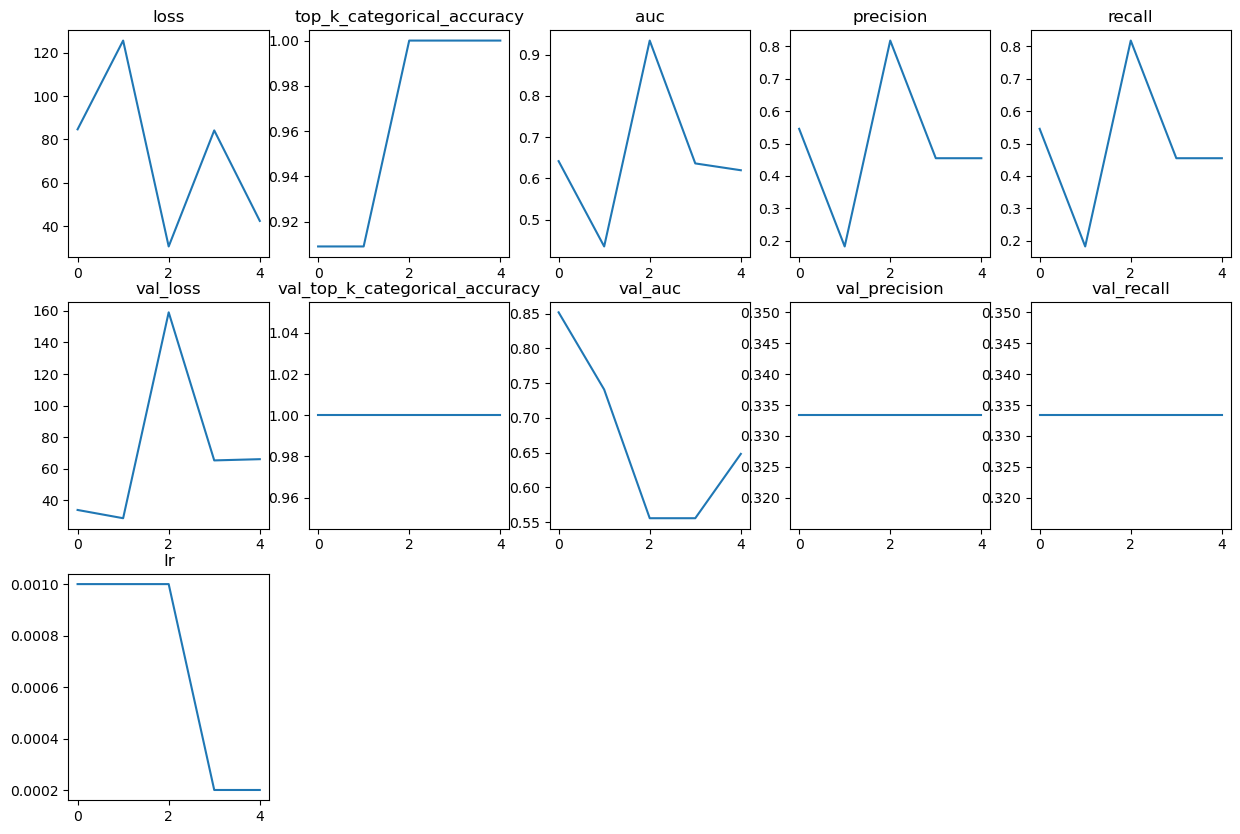

In [22]:
plot_history_metrics(conv_model_history)

In [23]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

2/2 [==============================] - 0s 157ms/step - loss: 66.0823 - top_k_categorical_accuracy: 1.0000 - auc: 0.6481 - precision: 0.3333 - recall: 0.3333
Loss : 66.08232879638672
Top 3 Categorical Accuracy : 1.0
Area under the Curve (ROC) : 0.6481481790542603
Precision : 0.3333333432674408
Recall : 0.3333333432674408
